## 1) Import Required Libraries

In [14]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [15]:
# Absolute summary CSV paths (user-provided)
commutor_dir = '/Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/commutator_noise/n6_limit0p0_turns4_maxround300_num200/comm_noise_summary_n6.csv'
linear_dir = '/Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_linear/n6_limit0p1_turns4_maxround300_num200/noise_linear_summary_n6_samples200.csv'
wppt_dir = '/Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_wppt/n6_limit0p1_turns4_maxround300/noise_wppt_summary_n6.csv'

for p in (commutor_dir, linear_dir, wppt_dir):
    print('Exists:', p, '->', Path(p).exists())

Exists: /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/commutator_noise/n6_limit0p0_turns4_maxround300_num200/comm_noise_summary_n6.csv -> True
Exists: /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_linear/n6_limit0p1_turns4_maxround300_num200/noise_linear_summary_n6_samples200.csv -> True
Exists: /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_wppt/n6_limit0p1_turns4_maxround300/noise_wppt_summary_n6.csv -> True


In [16]:
def load_and_prepare(path):
    if not path or not Path(path).exists():
        return None
    df = pd.read_csv(path)
    # Normalize round column
    if 'round' not in df.columns and 'step' in df.columns:
        df = df.rename(columns={'step': 'round'})
    if 'round' in df.columns:
        try:
            df['round'] = df['round'].astype(int)
        except Exception:
            pass
    # Determine clean column and rename to 'clean'
    clean_col = None
    for cand in ('clean_score','clean_trace','clean','trace','trace_witness'):
        if cand in df.columns:
            clean_col = cand
            break
    if clean_col is not None:
        df = df.rename(columns={clean_col: 'clean'})
    else:
        df['clean'] = np.nan
    # Ensure max_noise exists (best-effort)
    if 'max_noise' not in df.columns and 'max_noise' in df.columns:
        pass
    # Keep relevant columns only if present
    keep = [c for c in ['noise_type','round','max_noise','clean'] if c in df.columns]
    return df[keep] if keep else df

comm_df = load_and_prepare(commutor_dir)
linear_df = load_and_prepare(linear_dir)
wppt_df = load_and_prepare(wppt_dir)

print('Loaded: commutor', None if comm_df is None else comm_df.shape, 'linear', None if linear_df is None else linear_df.shape, 'wppt', None if wppt_df is None else wppt_df.shape)

Loaded: commutor (148, 4) linear (56, 4) wppt (42, 4)


In [17]:
# Map datasets to labels used in plots
datasets = {
    'fixed paulis': comm_df,
    'limit with linear SVM': linear_df,
    'limit with SDP': wppt_df,
}
# Noise types to plot
noise_types = ['white','bitflip']

# Helper to get dataframe for a noise type (filter by noise_type column if present)
def df_for_noise(df, noise):
    if df is None:
        return None
    if 'noise_type' in df.columns:
        sub = df[df['noise_type'] == noise].copy()
    else:
        # if no noise_type column, assume the file is for a single noise type and return as-is
        sub = df.copy()
    if sub.empty:
        return None
    # ensure round and max_noise and clean exist
    for col in ['round','max_noise','clean']:
        if col not in sub.columns:
            sub[col] = np.nan
    try:
        sub = sub.sort_values('round')
    except Exception:
        pass
    return sub

Saved figure to /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/compare_noise_results.png


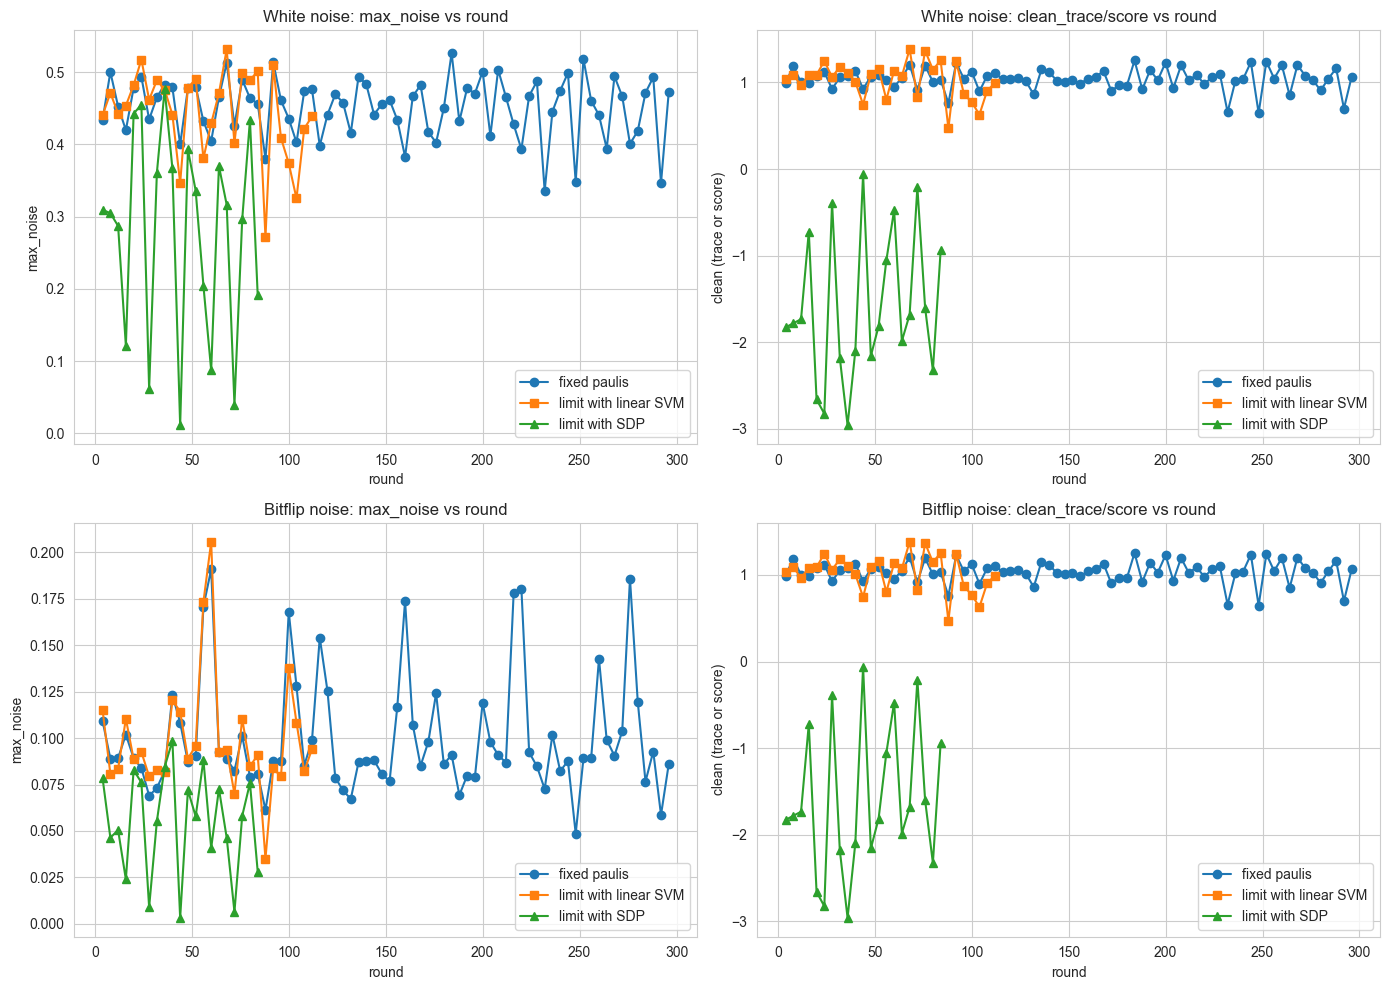

In [ ]:
# Plot 2x2: (white max_noise, white clean) x (bitflip max_noise, bitflip clean)
fig, axes = plt.subplots(1, 3, figsize=(14, 10))
ax1, ax2, ax3 = axes
colors = {'fixed paulis':"#e89e9e", 'limit with linear SVM':"#e8c19e", 'limit with SDP':"#dae19e"}
markers = {'fixed paulis':'o', 'limit with linear SVM':'s', 'limit with SDP':'^'}

# Top-left: white max_noise vs round
nt = 'white'
for label, df in datasets.items():
    sub = df_for_noise(df, nt)
    if sub is None:
        continue
    ax1.plot(sub['round'], sub['max_noise'], label=label, color=colors[label], marker=markers[label])
ax1.set_title('White noise: max_noise vs round')
ax1.set_xlabel('round')
ax1.set_ylabel('max_noise')
ax1.legend()
ax1.grid(True)

# Top-right: white clean vs round
for label, df in datasets.items():
    sub = df_for_noise(df, nt)
    if sub is None:
        continue
    ax2.plot(sub['round'], sub['clean'], label=label, color=colors[label], marker=markers[label])
# ax2.set_title('White noise: clean_trace/score vs round')
ax2.set_title('score/trace vs round')
ax2.set_xlabel('round')
ax2.set_ylabel('clean (trace or score)')
ax2.legend()
ax2.grid(True)

# Bottom-left: bitflip max_noise vs round
nt = 'bitflip'
for label, df in datasets.items():
    sub = df_for_noise(df, nt)
    if sub is None:
        continue
    ax3.plot(sub['round'], sub['max_noise'], label=label, color=colors[label], marker=markers[label])
ax3.set_title('Bitflip noise: max_noise vs round')
ax3.set_xlabel('round')
ax3.set_ylabel('max_noise')
ax3.legend()
ax3.grid(True)

# Bottom-right: bitflip clean vs round
# for label, df in datasets.items():
#     sub = df_for_noise(df, nt)
#     if sub is None:
#         continue
#     ax4.plot(sub['round'], sub['clean'], label=label, color=colors[label], marker=markers[label])
# ax4.set_title('Bitflip noise: clean_trace/score vs round')
# ax4.set_xlabel('round')
# ax4.set_ylabel('clean (trace or score)')
# ax4.legend()
# ax4.grid(True)

plt.tight_layout()
out_path = os.path.join(os.getcwd(), 'compare_noise_results.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
print('Saved figure to', out_path)
plt.show()

In [19]:
# Show a few rows from each prepared summary for quick inspection
for label, df in datasets.items():
    print('---', label, '---')
    display(None if df is None else (df.head() if hasattr(df, 'head') else df))

--- fixed paulis ---


,noise_type,round,max_noise,clean
0,bitflip,4,0.109189,0.991825
1,white,4,0.433941,0.991825
2,bitflip,8,0.088893,1.188494
3,white,8,0.500309,1.188494
4,bitflip,12,0.089259,1.000574


--- limit with linear SVM ---


,noise_type,round,max_noise,clean
0,white,4,0.440316,1.039817
1,bitflip,4,0.114923,1.039817
2,white,8,0.471346,1.089518
3,bitflip,8,0.080785,1.089518
4,white,12,0.442760,0.966253


--- limit with SDP ---


,noise_type,round,max_noise,clean
0,white,4,0.309422,-1.829692
1,bitflip,4,0.078277,-1.829692
2,white,8,0.304934,-1.781509
3,bitflip,8,0.046414,-1.781509
4,white,12,0.287147,-1.734648


In [20]:
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

## 2) Load Data from Result Directories

In [21]:
# Absolute paths (as requested)
commutor_dir = '/Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/commutator_noise/n6_limit0p0_turns4_maxround300_num200/comm_noise_summary_n6.csv'
linear_dir = '/Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_linear/n6_limit0p1_turns4_maxround300_num200/noise_linear_summary_n6_samples200.csv'
wppt_dir = '/Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_wppt/n6_limit0p1_turns4_maxround300/noise_wppt_summary_n6.csv'

for p in (commutor_dir, linear_dir, wppt_dir):
    print('Exists:', p, '->', Path(p).exists())

Exists: /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/commutator_noise/n6_limit0p0_turns4_maxround300_num200/comm_noise_summary_n6.csv -> True
Exists: /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_linear/n6_limit0p1_turns4_maxround300_num200/noise_linear_summary_n6_samples200.csv -> True
Exists: /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_wppt/n6_limit0p1_turns4_maxround300/noise_wppt_summary_n6.csv -> True


## 3) Parse and Organize Results
Helper functions to locate combined CSVs and aggregate per round.

In [24]:
def find_combined_csv(folder, patterns):
    folder = Path(folder)
    for pat in patterns:
        matches = sorted(folder.glob(pat))
        if matches:
            return str(matches[0])
    return None

def load_and_normalize(path):
    if path is None:
        return None
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f'Could not read {path}: {e}')
        return None

    # Ensure 'round' column exists
    if 'round' not in df.columns and 'step' in df.columns:
        df = df.rename(columns={'step': 'round'})

    if 'round' in df.columns:
        try:
            df['round'] = df['round'].astype(int)
        except Exception:
            pass

    # Standardize clean column: prefer clean_score -> clean_trace -> trace
    clean_col = None
    for cand in ('clean_score', 'clean_trace', 'trace', 'trace_witness'):
        if cand in df.columns:
            clean_col = cand
            break
    if clean_col is not None:
        df = df.rename(columns={clean_col: 'clean'})
    else:
        df['clean'] = np.nan

    # Ensure max_noise exists (it should)
    if 'max_noise' not in df.columns and 'max_noise' in df.columns:
        pass

    return df

def aggregate_by_round(df):
    if df is None or df.empty:
        return pd.DataFrame(columns=['round', 'max_noise', 'clean'])
    # Group by round, take max of max_noise and first non-null clean
    g = df.groupby('round', as_index=False)
    out = g.agg({'max_noise': 'max'})
    # pick clean: first non-null
    cleans = []
    for r, sub in g:
        vals = sub['clean'].dropna().values
        cleans.append(vals[0] if len(vals)>0 else np.nan)
    out['clean'] = cleans
    return out.sort_values('round')

In [25]:
# Patterns for each folder type
def load_combined_for(folder, noise_type, kind):
    # kind in ('comm', 'linear', 'wppt')
    if kind == 'comm':
        patterns = [f'comm_noise_combined_{noise_type}_*.csv']
    elif kind == 'linear':
        patterns = [f'noise_linear_combined_{noise_type}_*.csv']
    elif kind == 'wppt':
        patterns = [f'noise_wppt_combined_{noise_type}_*.csv']
    else:
        return None

    path = find_combined_csv(folder, patterns)
    if path is None:
        print(f'No combined CSV found in {folder} for {noise_type} ({kind})')
        return None
    print('Loading', path)
    df = load_and_normalize(path)
    return aggregate_by_round(df)

# Load for both noise types and all three methods
noise_types = ['white', 'bitflip']
results = {nt: {} for nt in noise_types}
for nt in noise_types:
    results[nt]['fixed paulis'] = load_combined_for(commutor_dir, nt, 'comm')
    results[nt]['limit with linear SVM'] = load_combined_for(linear_dir, nt, 'linear')
    results[nt]['limit with SDP'] = load_combined_for(wppt_dir, nt, 'wppt')

# Quick peek
for nt in noise_types:
    print('====', nt, '====')
    for k, df in results[nt].items():
        print(k, 'rows:', df.shape[0])

No combined CSV found in /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/commutator_noise/n6_limit0p0_turns4_maxround300_num200/comm_noise_summary_n6.csv for white (comm)
No combined CSV found in /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_linear/n6_limit0p1_turns4_maxround300_num200/noise_linear_summary_n6_samples200.csv for white (linear)
No combined CSV found in /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_wppt/n6_limit0p1_turns4_maxround300/noise_wppt_summary_n6.csv for white (wppt)
No combined CSV found in /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/commutator_noise/n6_limit0p0_turns4_maxround300_num200/comm_noise_summary_n6.csv for bitflip (comm)
No combined CSV found in /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/result/noise_li

AttributeError: 'NoneType' object has no attribute 'shape'

## 4-7) Plot comparisons
Four subplots: max_noise and clean (trace/score) for white and bitflip.

/var/folders/f_/9clb1_bn6jd2drlb843x8jqr0000gn/T/ipykernel_38986/3810995461.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/f_/9clb1_bn6jd2drlb843x8jqr0000gn/T/ipykernel_38986/3810995461.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/var/folders/f_/9clb1_bn6jd2drlb843x8jqr0000gn/T/ipykernel_38986/3810995461.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()
/var/folders/f_/9clb1_bn6jd2drlb843x8jqr0000gn/T/ipykernel_38986/3810995461.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an undersco

Saved figure to /Users/jiayiwu/Library/CloudStorage/OneDrive-TheUniversityofHongKong-Connect/GitHub/SVM/compare_noise_results.png


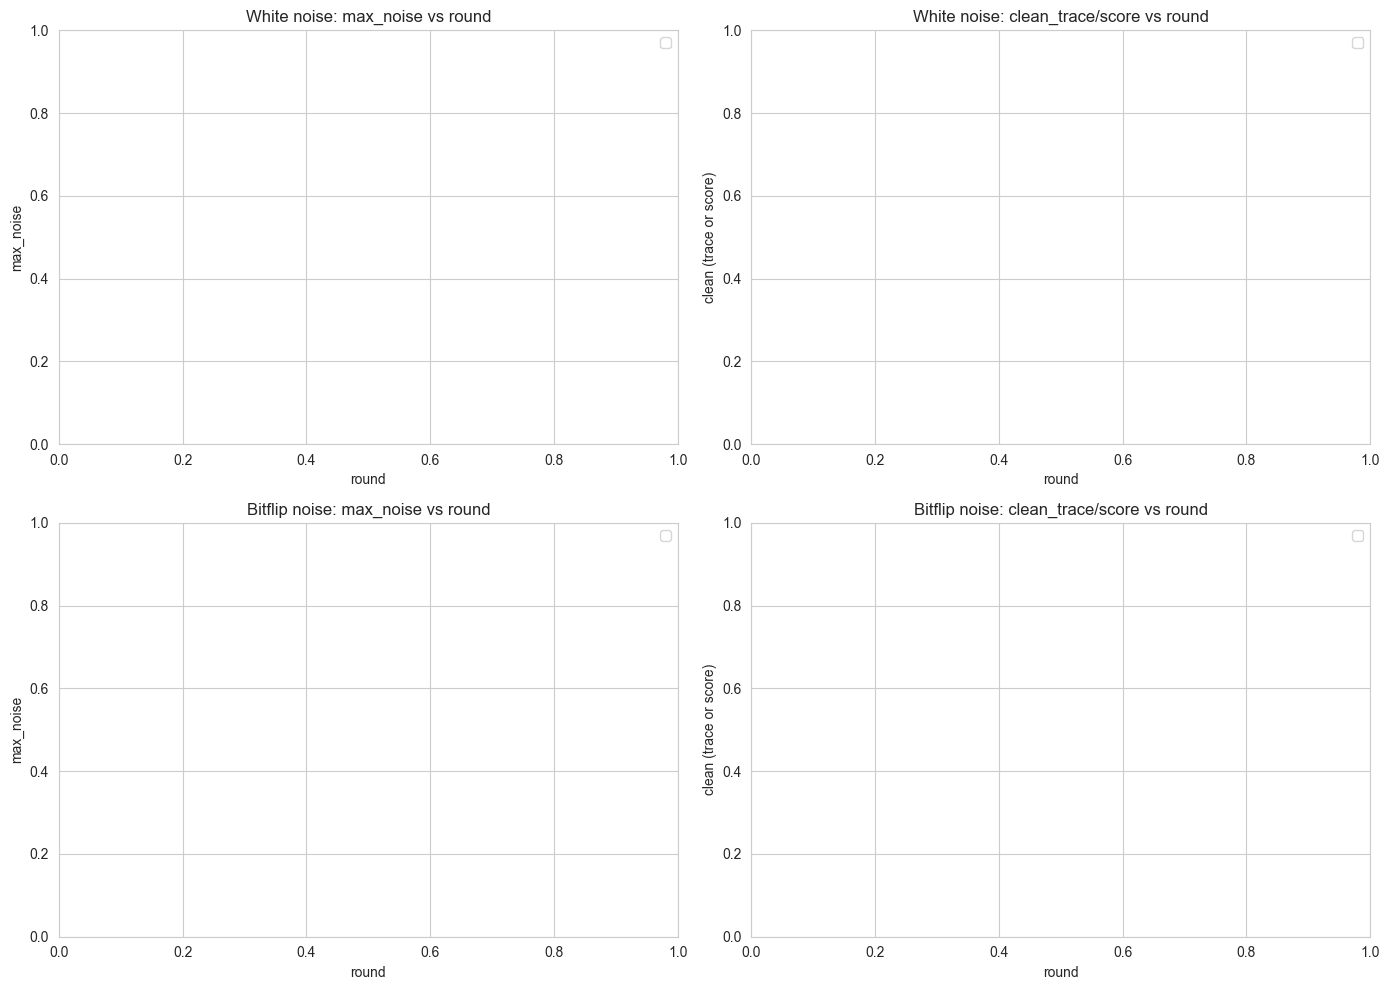

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False)
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]
colors = {'fixed paulis':'C0', 'limit with linear SVM':'C1', 'limit with SDP':'C2'}
markers = {'fixed paulis':'o', 'limit with linear SVM':'s', 'limit with SDP':'^'}

# Top-left: white max_noise vs round
nt = 'white'
for label in ['fixed paulis','limit with linear SVM','limit with SDP']:
    df = results[nt].get(label)
    if df is None or df.empty:
        continue
    ax1.plot(df['round'], df['max_noise'], label=label, color=colors[label], marker=markers[label])
ax1.set_title('White noise: max_noise vs round')
ax1.set_xlabel('round')
ax1.set_ylabel('max_noise')
ax1.legend()
ax1.grid(True)

# Top-right: white clean vs round
for label in ['fixed paulis','limit with linear SVM','limit with SDP']:
    df = results[nt].get(label)
    if df is None or df.empty:
        continue
    ax2.plot(df['round'], df['clean'], label=label, color=colors[label], marker=markers[label])
ax2.set_title('White noise: clean_trace/score vs round')
ax2.set_xlabel('round')
ax2.set_ylabel('clean (trace or score)')
ax2.legend()
ax2.grid(True)

# Bottom-left: bitflip max_noise vs round
nt = 'bitflip'
for label in ['fixed paulis','limit with linear SVM','limit with SDP']:
    df = results[nt].get(label)
    if df is None or df.empty:
        continue
    ax3.plot(df['round'], df['max_noise'], label=label, color=colors[label], marker=markers[label])
ax3.set_title('Bitflip noise: max_noise vs round')
ax3.set_xlabel('round')
ax3.set_ylabel('max_noise')
ax3.legend()
ax3.grid(True)

# Bottom-right: bitflip clean vs round
for label in ['fixed paulis','limit with linear SVM','limit with SDP']:
    df = results['bitflip'].get(label)
    if df is None or df.empty:
        continue
    ax4.plot(df['round'], df['clean'], label=label, color=colors[label], marker=markers[label])
ax4.set_title('Bitflip noise: clean_trace/score vs round')
ax4.set_xlabel('round')
ax4.set_ylabel('clean (trace or score)')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
out_path = os.path.join(os.getcwd(), 'compare_noise_results.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
print('Saved figure to', out_path)
plt.show()

## 8) Summary tables
Show top rows of aggregated data for a quick check.

In [ ]:
for nt in ['white','bitflip']:
    print('
===', nt, '===')
    for label, df in results[nt].items():
        print('
--', label, '--')
        display(df.head(5))

---
Notes:
- The notebook searches for *combined* CSV files in the provided folders. If your files have different names, update the glob patterns in the `find_combined_csv` helper.
- `clean` column is unified from `clean_score`, `clean_trace`, or `trace_witness` when available.
- If any folder is missing or CSV files are not present, the notebook will report missing files and skip those lines.